In [961]:
import nltk
#nltk.download('all')
nltk.download('wordnet')
import pandas as pd
pd.set_option('display.max_rows', None)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# translate punctuation
import string

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [962]:
#import lyrics
data = pd.read_csv('artist_song_lyrics_extended.csv')

# Data Cleaning

In [963]:
# define function to separate lyrics/bars
def get_bars(text):
    
    # use comma separator to separate bars
    bars = text.split(',')

    # Check if any bar contains u2005
    if any("\\u2005" in bar for bar in bars):
        # Remove u2005 string
        bars = [bar.replace("\\u2005", "") for bar in bars]

        # Create translator that replaces punctuation with empty spaces
        translator = str.maketrans("", "", string.punctuation)
    
        # Remove punctuation from each bar
        clean_bars = [bar.translate(translator).lower() for bar in bars]
    else:

        # Create translator that replaces punctuation with empty spaces
        translator = str.maketrans("", "", string.punctuation)
    
        # Remove punctuation from each bar
        clean_bars = [bar.translate(translator).lower() for bar in bars]
        
    return (clean_bars)

data['Lyrics'] = data['Lyrics'].apply(get_bars)

In [964]:
#define function for removing punctuation from within a string
import re

def remove_punctuation_regex(text):
    return re.sub(r'[^\w\s]', '', text)

In [965]:
# explode the Lyrics column so that the nested lists (bars) are assigned to invidual rows
df_exploded = data.explode('Lyrics').reset_index(drop=True)

In [966]:
# Remove words that are unique to this lyrics dataset (e.g. verse, chorus, bridge, 1, 2, 3
df_exploded['Lyrics'] = df_exploded['Lyrics'].apply(lambda x: x.replace('chorus','').replace('verse','').replace('bridge','').replace('1','').replace('2','').replace('drake','').replace('intro','').replace('outro','').replace('rick ross','').replace('meek mill','').replace('pusha t','') if isinstance(x, str) else x)

#remove punctuation
df_exploded['Lyrics'] = df_exploded['Lyrics'].apply(remove_punctuation_regex)

# remove white space created by empty strings then 
df_exploded = df_exploded.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#delete rows where len of string value is 0
df_exploded = df_exploded[df_exploded.apply(lambda x: x.str.len() > 0).all(axis=1)]

C:\Users\theri\AppData\Local\Temp\ipykernel_36544\2299741231.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_exploded = df_exploded.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [967]:
df_exploded.reset_index(drop=True, inplace=True)

# Data Preprocessing

In [968]:
#tokenize lyrics and remove stop words
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Reconstruct the text
    processed_text = ' '.join(lemmatized_tokens)

    return(processed_text)

#apply the function to the Lyrics column of cleaned_data
df_exploded['Lyrics'] = df_exploded['Lyrics'].apply(preprocess_text)

In [969]:
df_exploded.reset_index(drop=True, inplace=True)

In [970]:
# Remove words that are unique to this lyrics dataset (e.g. verse, chorus, bridge, 1, 2, 3
#df_exploded['Lyrics'] = df_exploded['Lyrics'].apply(lambda x: x.replace('chorus','').replace('verse','').replace('bridge','').replace('1','').replace('2','').replace("'",'').replace('drake','').replace(",",'').replace('intro','').replace('outro','').replace('rick ross','').replace('meek mill','').replace('pusha t','') if isinstance(x, str) else x)

# remove white space created by empty strings then delete rows where len of string value is 0
df_exploded = df_exploded.apply(lambda x: x.strip() if isinstance(x, str) else x)

df_exploded = df_exploded[df_exploded.apply(lambda x: x.str.len() > 0).all(axis=1)]

# NLTK Sentiment Analyzer

In [971]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\theri\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [972]:
# initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [973]:
# create get_sentiment function
def get_sentiment(text):

    scores = analyzer.polarity_scores(text)

    sentiment = 1 if scores['pos'] > 0 else 0

    return sentiment

In [974]:
# apply get_sentiment function

df_exploded['sentiment'] = df_exploded['Lyrics'].apply(get_sentiment)

In [975]:
# convert sentiment ratings to string values
df_exploded['sentiment'] = df_exploded['sentiment'].apply(lambda x: 'positive' if x == 1 else 'negative')

# Visualization

In [976]:
import seaborn as sns
import matplotlib.pyplot as plt

In [977]:
#define function to plot side-by-side pie charts that show percentages of negative and positive sentiment for defined groups
def pie_charts(arg1, arg2, arg3, arg4):
    '''
    arg1: dataframe
    arg2: first column to groupby
    arg3: second column to groupby
    arg4: title of output file
    '''
    # Step 1: Aggregate sentiment counts by artist
    grouped_sentiment = arg1.groupby([arg2, arg3]).size().unstack(fill_value=0)
    
    # Step 2: Calculate percentage of negative and positive sentiment for each artist
    artist_sentiment_percentage = {}
    for artist, row in grouped_sentiment.iterrows():
        total = row.sum()
        negative = row.get('negative', 0)
        positive = row.get('positive', 0)
        negative_percentage = (negative / total) * 100
        positive_percentage = (positive / total) * 100
        artist_sentiment_percentage[artist] = {'negative': negative_percentage, 'positive': positive_percentage}
    
    # Step 3: Plot pie charts for all artists in a single row
    num_artists = len(artist_sentiment_percentage)
    fig, axes = plt.subplots(1, num_artists, figsize=(6*num_artists, 6))
    
    for i, (artist, percentages) in enumerate(artist_sentiment_percentage.items()):
        labels = ['Negative', 'Positive']
        sizes = [percentages['negative'], percentages['positive']]
        #colors = ['blue', 'green']
        #axes[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
        axes[i].set_title('Sentiment Percentages for ' + artist) 
        axes[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.tight_layout()
    plt.savefig('%s.png' % (arg4))
    plt.show()
    

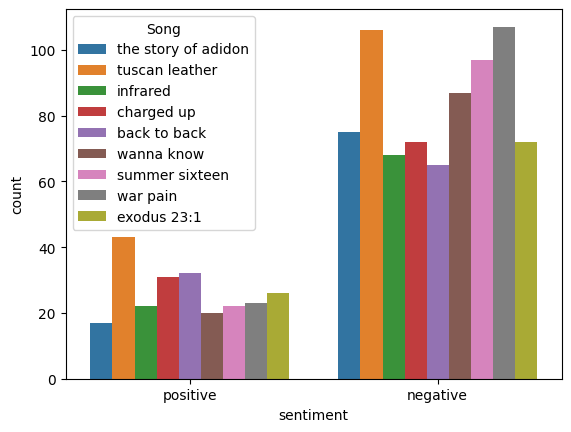

In [978]:
# Create countplot with color legend based on another column
sns.countplot(x='sentiment', hue='Song', data=df_exploded)

# Show plot
plt.show()

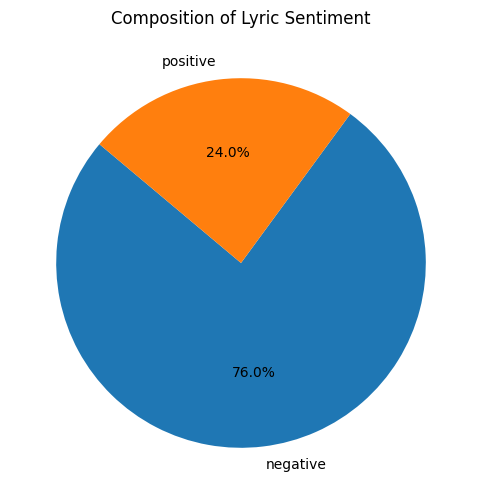

In [979]:
# Create a pie chart

data = df_exploded

# Count the occurrences of each artist in the 'Artist' column
sentiment_counts = data['sentiment'].value_counts()

# Calculate the percentage of total value counts for each artist
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_percentages, labels=sentiment_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Composition of Lyric Sentiment')
plt.savefig('lyric_sentiment_allsongs.png')
plt.show()


We can see that the majority of the lyrical content in all of the songs contains language that is classified as negative by the sentiment analyzer. 76\% of the lyrics' content is classified as negative while 24\% is classified as positive.

Now let's look at negative and positive sentiment percentages for the individual artists.

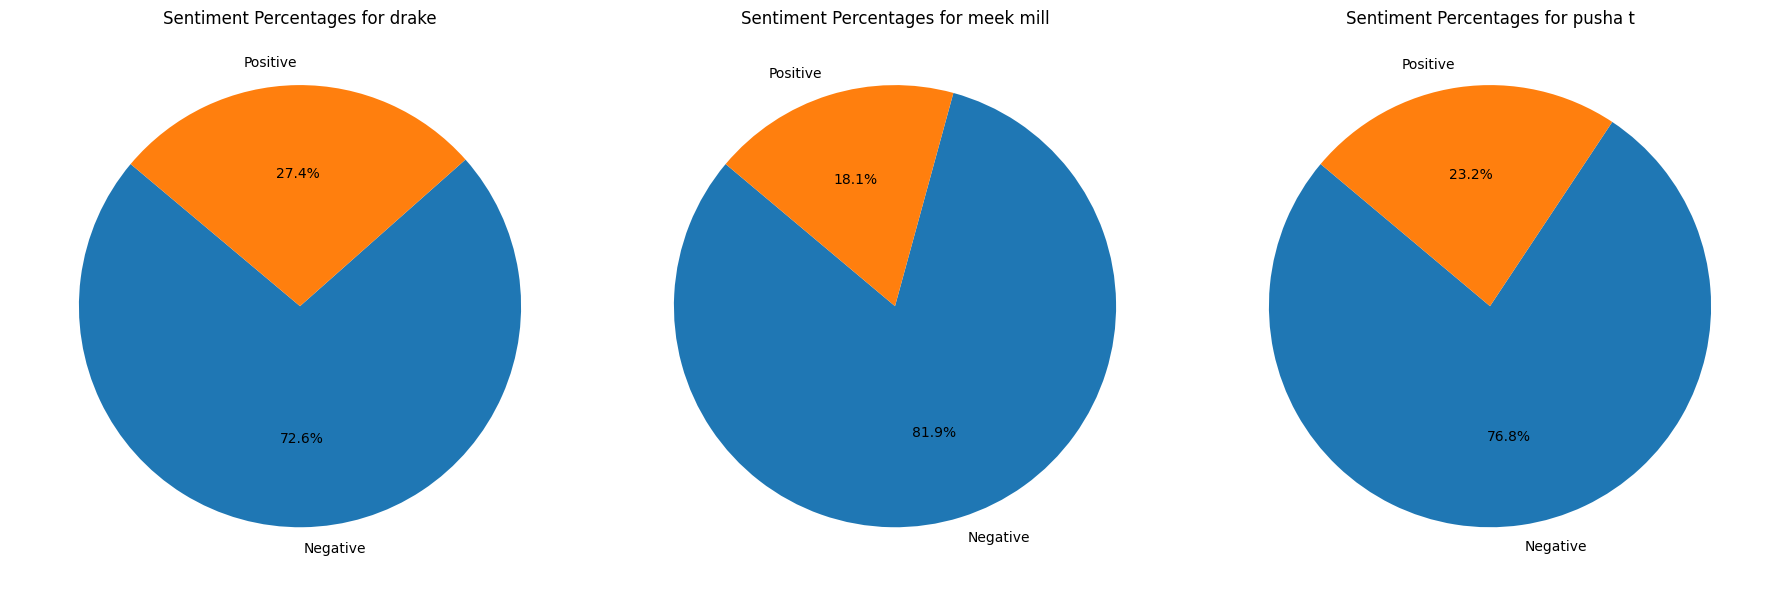

In [980]:
pie_charts(df_exploded,'Artist','sentiment','sentiment_pct_allartists')

The ratio of negative to positive sentiment is smallest for Drake's songs. Drake's songs contain about 4.4% fewer negative lyrics than the other rappers. Let's look at this ratio as it pertains to specific beefs that Drake has been involved in over the years, starting with the Pusha T beef. 

In [981]:
# Lets get the subset of data that pertains to the Drake and Pusha T beef.
drake_pushat = df_exploded[(df_exploded['Song'] == 'the story of adidon') | (df_exploded['Song'] == 'tuscan leather') | (df_exploded['Song'] == 'exodus 23:1') | (df_exploded['Song'] == 'infrared')]

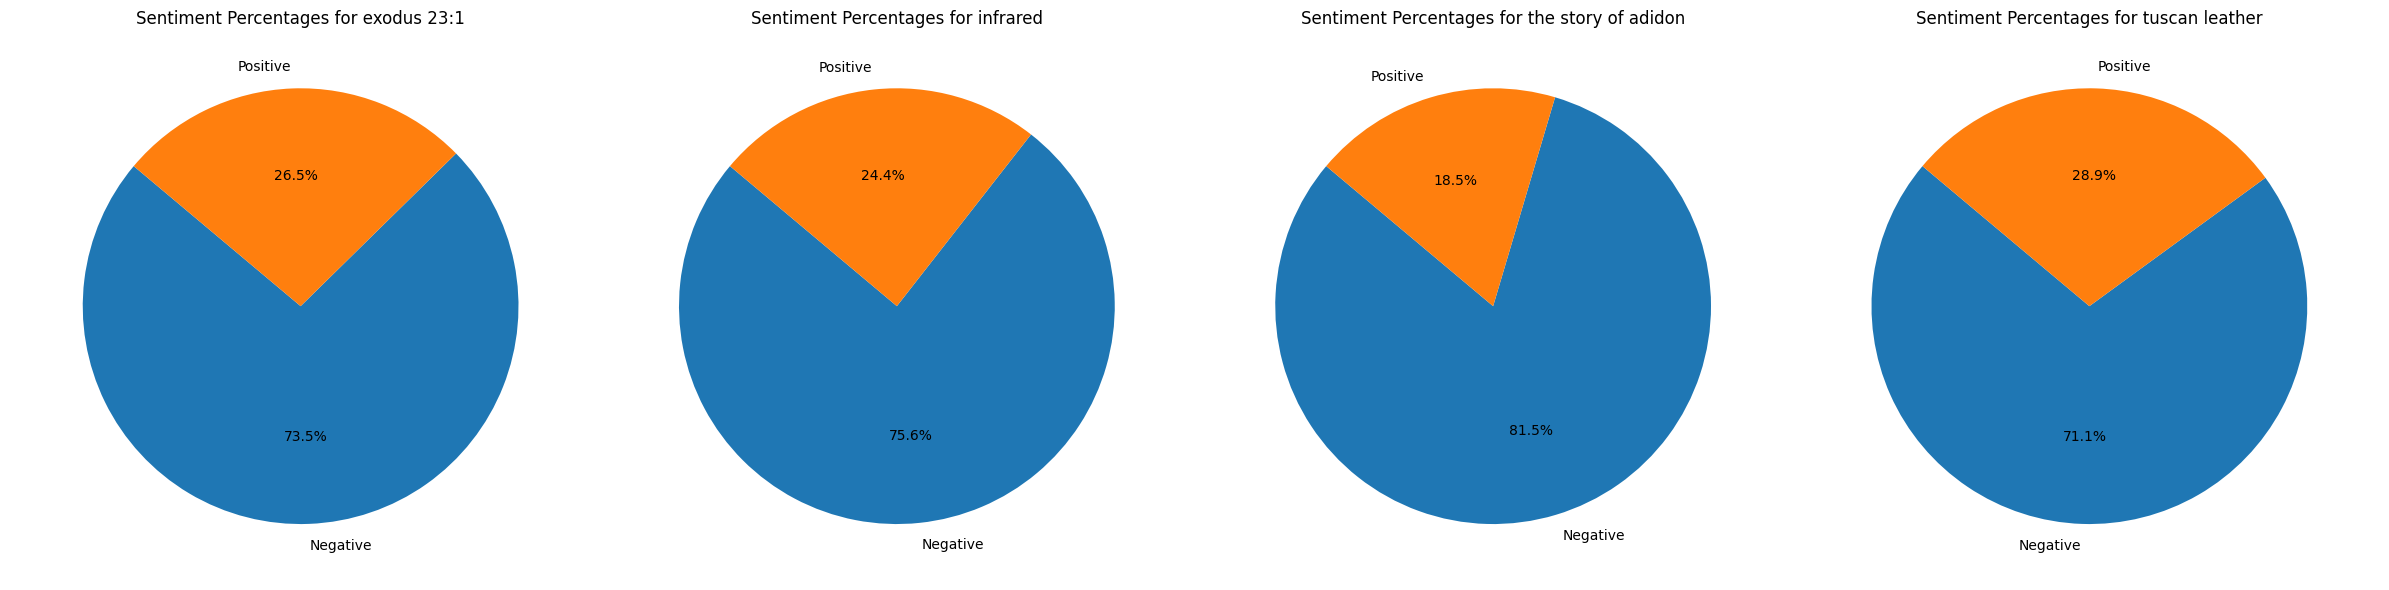

In [982]:
pie_charts(drake_pushat,'Song','sentiment','sentiment_pct_drake_vs_pushat')

Again, the ratio of negative to positive sentiment is least for Drake's ONLY song in this beef, Tuscan Leather. Tuscan Leather contains about 5.7% fewer negative lyrics than Pusha T's songs. According to a report by Rap Radar in 2019, Drake conceded that he had lost his feud with Pusha T...

https://www.youtube.com/watch?v=mmsasEoupO4

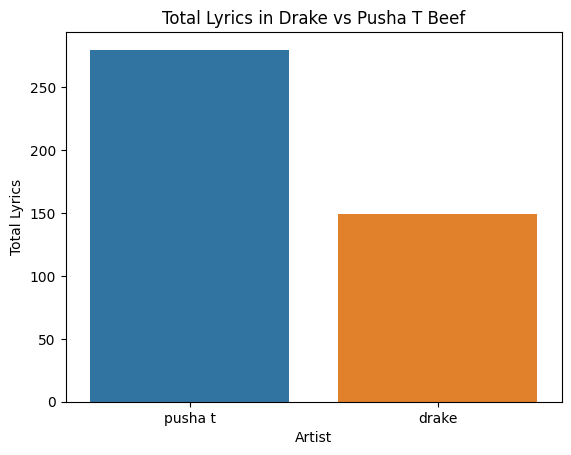

In [983]:
# Create countplot with color legend based on another column
sns.countplot(x='Artist', hue='Artist', data=drake_pushat)

# Show plot
plt.ylabel('Total Lyrics')
plt.title('Total Lyrics in Drake vs Pusha T Beef')
plt.savefig('total_lyrics_drake_vs_pushat.png')
plt.show()



#plt.savefig('drake_vs_pusha.png')

Pusha T's combined lyrics exceeded Drake's mainly because Pusha created 3 songs to Drake's 1.

Now, let's look at the Drake vs Meek Mill beef, where Drake created 3 songs to Meek's 2.

In [984]:
# now lets look at drake and meek mill
drake_meek = df_exploded[(df_exploded['Song'] == 'charged up') | (df_exploded['Song'] == 'back to back') | (df_exploded['Song'] == 'wanna know') | (df_exploded['Song'] == 'summer sixteen') | (df_exploded['Song'] == 'war pain')]


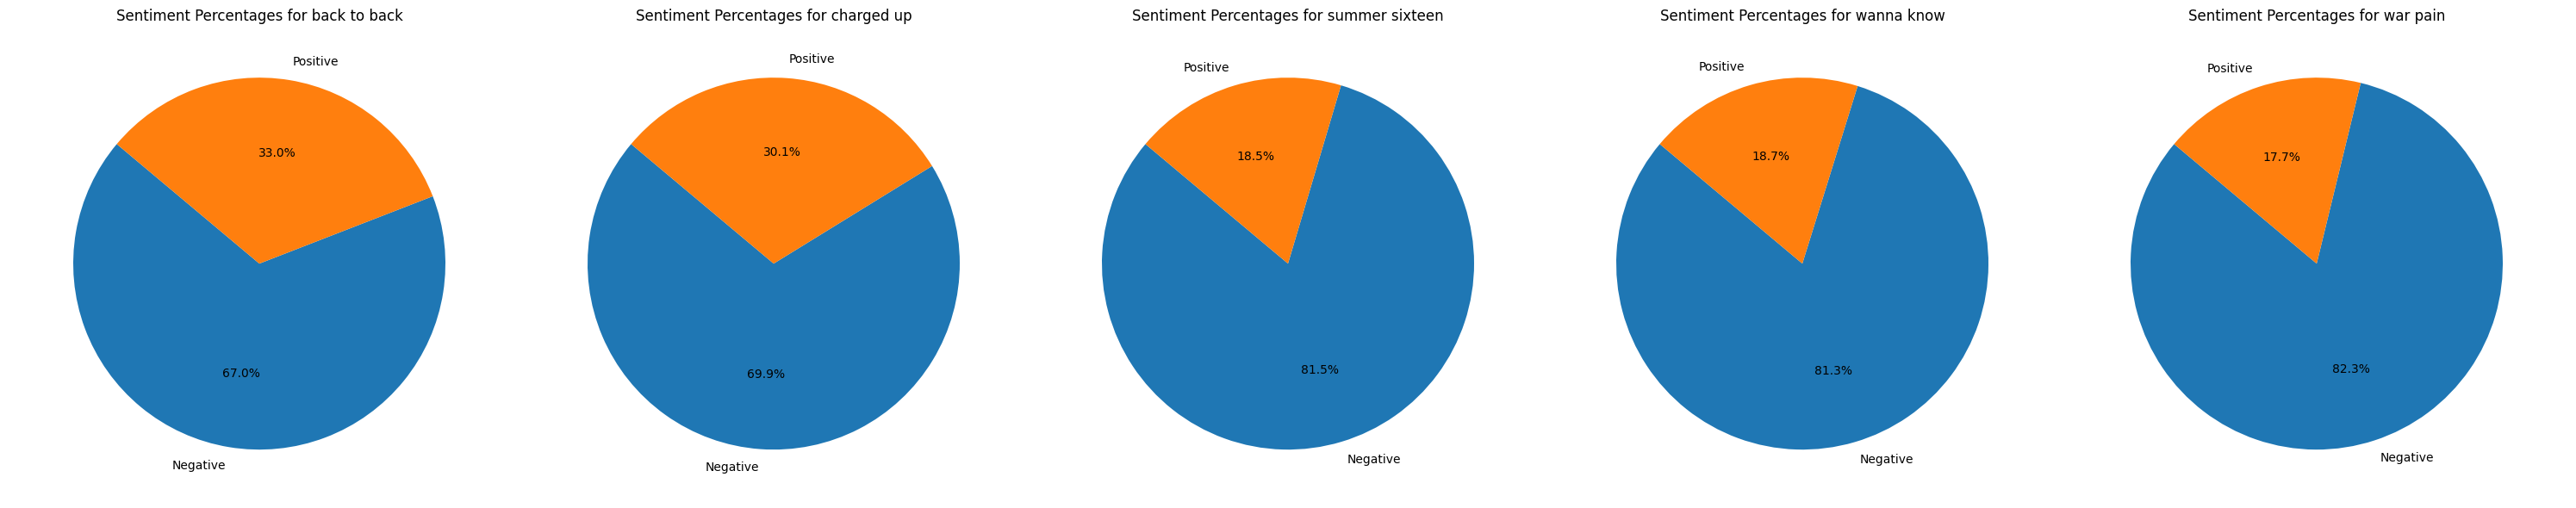

In [985]:
pie_charts(drake_meek,'Song','sentiment','sentiment_pct_drake_vs_meekmill')

Again, Drake's lyrics have less negative sentitment than his opponent's lyrics (excluding Drake's *Summer Sixteen* which was as negative in sentiment as Meek Mill's two songs in this beef). Meek Mill's lyrics contained about 9\% more negative lyrics than Drake's. Overall, Drake was considered the winner of this beef. The two rappers made peace in 2018 when Drake brought Meek out on stage to perform at one of his shows in Boston.

https://www.rollingstone.com/music/music-news/watch-drake-and-meek-mill-squash-beef-at-boston-concert-721613

Statistically, it appears that vulgarity had less influence than quantity when deciding a winner. For both beefs, the rapper with more lyrics won despite their opponent's lyrical aggressiveness.

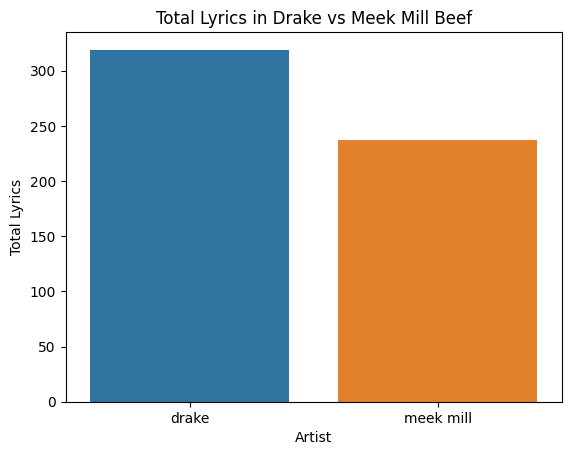

In [986]:
# Create countplot with color legend based on another column
sns.countplot(x='Artist', hue='Artist', data=drake_meek)

# Show plot
plt.ylabel("Total Lyrics")
plt.title('Total Lyrics in Drake vs Meek Mill Beef')
plt.savefig('total_lyrics_drake_vs_meekmill.png')
plt.show()

In [987]:
from wordcloud import WordCloud

In [988]:
def censor_text(text):
    censored_text = text
    censored_text = censored_text.replace("nigga", "nword")
    censored_text = censored_text.replace("bitch", "bword")
    censored_text = censored_text.replace("fuck", "fbomb")
    censored_text = censored_text.replace("shit", "sbomb")
    censored_text = censored_text.replace("muthafucka", "mfer")
    return censored_text

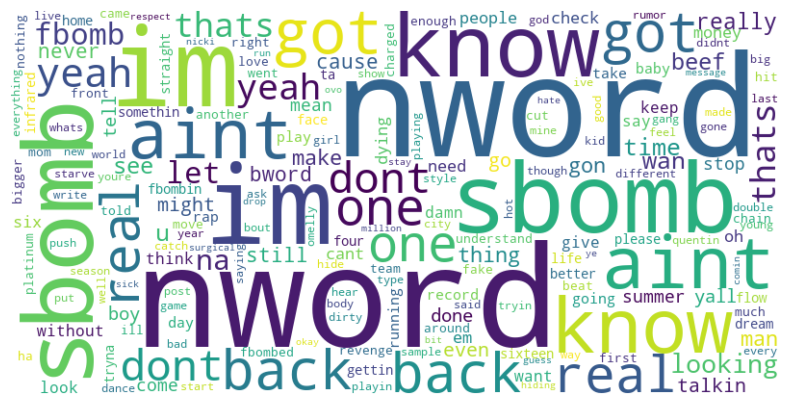

In [998]:
# Concatenate values in the 'text_column' into a single string
text = df_exploded['Lyrics'].str.cat(sep=' ')

censored_text = censor_text(text)


# Create word cloud
wordcloud = WordCloud(regexp=r'\b\w+\b|\**',width=800, height=400, background_color='white').generate(censored_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.png')
plt.show()